<a href="https://colab.research.google.com/github/eunyhwang/Debiasing_BERT/blob/main/BiasBERT_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unwanted bias in BERT
Using HuggingFace Transformers

In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 12.3 MB/s 
     |████████████████████████████████| 895 kB 64.6 MB/s 
     |████████████████████████████████| 636 kB 64.6 MB/s 
     |████████████████████████████████| 3.3 MB 74.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
#Preprocessing

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") #bert-base-cased: This model is case-sensitive: it makes a difference between english and English.
model = AutoModel.from_pretrained("bert-base-cased")


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
inputs = tokenizer("Hello world!", return_tensors="pt")
#print(inputs)
outputs = model(**inputs)
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3763,  0.3677,  0.4943,  ..., -0.1661,  0.5943, -0.1593],
         [ 0.7121, -0.3679,  0.8583,  ..., -0.2390,  0.5696, -0.0886],
         [ 0.6560,  0.4704,  0.4859,  ..., -0.5636, -0.2622, -0.4754],
         [ 0.6384,  0.0811,  0.8182,  ...,  0.2685,  0.3920,  0.1553],
         [ 0.7409,  0.5910,  0.3281,  ..., -0.3253,  0.9761, -0.7480]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-0.7344,  0.5340,  0.9999, -0.9965,  0.9731,  0.9413,  0.9889, -0.9936,
         -0.9909, -0.6240,  0.9881,  0.9992, -0.9987, -0.9999,  0.8453, -0.9851,
          0.9928, -0.5935, -1.0000, -0.7785, -0.6099, -0.9999,  0.3129,  0.9706,
          0.9839,  0.1030,  0.9904,  1.0000,  0.9293, -0.1514,  0.2855, -0.9940,
          0.8683, -0.9991,  0.1395,  0.1552,  0.7852, -0.2933,  0.8666, -0.9264,
         -0.8684, -0.7063,  0.7907, -0.6058,  0.9745,  0.3654, -0.1007, -0.0275,
          0.0131,  0.9998, -0.9763,  

The tokenizer will first split a given text in words (or part of words, punctuation symbols, etc.) usually called tokens. Then it will convert those tokens into numbers, to be able to build a tensor out of them and feed them to the model. It will also add any additional inputs the model might expect to work properly.
**note:** If you plan on using a pretrained model, it’s important to use the associated pretrained tokenizer: it will split the text you give it in tokens the same way for the pretraining corpus, and it will use the same correspondence token to index (that we usually call a vocab) as during pretraining.
To automatically download the vocab used during pretraining or fine-tuning a given model, you can use the from_pretrained() method:

In [18]:
out1, out2 = outputs
print(out1, out2)
#print(out1.shape)
#print(out2.shape)

last_hidden_state pooler_output


In [19]:
import math

def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))


def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return numerator/float(denominator)

In [10]:
inputs1 = tokenizer("Jamal is a good.", return_tensors="pt")
outputs1 = model(**inputs1)

inputs2 = tokenizer("Jamal is a bad.", return_tensors="pt")
outputs2 = model(**inputs2)

inputs0 = tokenizer("Jamal is a [MASK].", return_tensors="pt")
outputs0 = model(**inputs0)

mask_id = list(inputs0['input_ids'][0]).index(103)
mask_id

4

In [ ]:
print(cosine_similarity(outputs0[0][0][mask_id], outputs1[0][0][mask_id]))
print(cosine_similarity(outputs0[0][0][mask_id], outputs2[0][0][mask_id]))

tensor(0.7354, grad_fn=<DivBackward0>)
tensor(0.7501, grad_fn=<DivBackward0>)


## Bias in Names
List from Discrimination in Online Ad Delivery: https://arxiv.org/abs/1301.6822

In [20]:
wf = ['Allison', 'Anne', 'Carrie', 'Emily', 'Jill', 'Laurie', 'Kristen', 'Meredith', 'Molly', 'Amy', 'Claire', 'Katie', 'Madeline', 'Katelyn', 'Emma']
wm = ['Brad', 'Brendan', 'Geoffrey', 'Greg', 'Brett', 'Jay', 'Matthew', 'Neil', 'Jake', 'Connor', 'Tanner', 'Wyatt', 'Cody', 'Dustin', 'Luke', 'Jack']
bf = ["Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Imani", "Shanice", "Aaliyah", "Precious", "Nia", "Deja", "Diamond", "Latanya", "Latisha"]
bm = ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "DeShawn", "DeAndre", "Marquis", "Malik", "Trevon", "Tyrone"]
#o = ["Eunyoung"] # Me

names = wf + wm + bf + bm + o

In [21]:
import numpy as np

def sentences(name,
              sentence,
              vars=["[MASK]", "good", "bad"]):
    mask = sentence.format(name, vars[0])
    good = sentence.format(name, vars[1])
    bad = sentence.format(name, vars[2])
    return mask, good, bad

def similarities(name, tokenizer, model,
                 sentence="{} is {}.",
                 vars=["[MASK]", "good", "bad"]):
    s = sentences(name, sentence, vars)
    inputs = tokenizer(s, return_tensors="pt")
    mask_id = list(inputs['input_ids'][0]).index(103)

    outputs = model(**inputs)

    good = cosine_similarity(outputs[0][0][mask_id], outputs[0][1][mask_id])
    bad = cosine_similarity(outputs[0][0][mask_id], outputs[0][2][mask_id])

    return np.array([good.detach().numpy(), bad.detach().numpy()])

In [22]:
from tqdm.notebook import tqdm


sentence1 = "{} is {}."
sentence2 = "{} is an {}."

#vars1 = ["[MASK]", "rich", "poor"]
vars1 = ["[MASK]", "right","wrong"]
vars2 = ["[MASK]", "actor", "actress"]
sims = []
for name in tqdm(names):
    s1_val = similarities(name, tokenizer, model, sentence1, vars1)
    s1_val = s1_val[0] - s1_val[1]

    s2_val = similarities(name, tokenizer, model, sentence2, vars2)
    s2_val = s2_val[0] - s2_val[1]

    sims.append([name, s1_val, s2_val])

TypeError: ignored

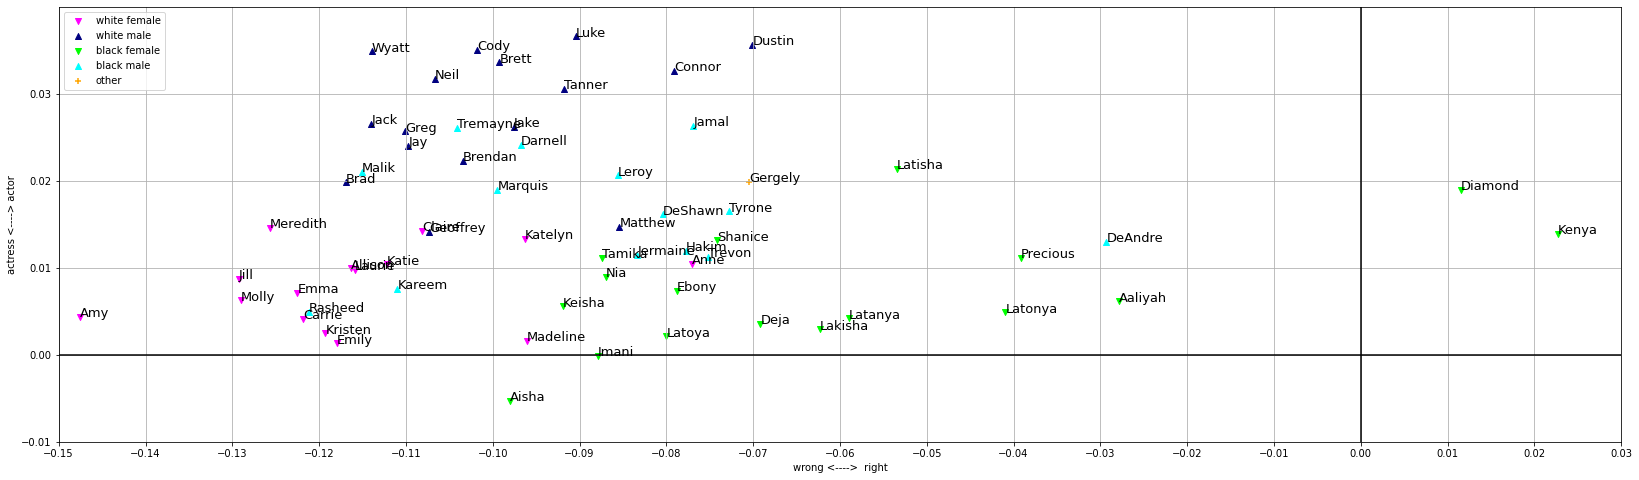

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = {"white female":False, "white male":False, "black male":False, "black female":False, "other":False}


fig = plt.figure(figsize=(28,8))
ax = fig.add_subplot(1, 1, 1)
for item in sims:
    n, v1, v2 = item
    if n in wf:
        l = "white female"
        mr = "v"
        color_value = 'magenta'
    elif n in wm:
        l = "white male"
        mr = "^"
        color_value = 'navy'
    elif n in bf:
        l = "black female"
        mr = "v"
        color_value = 'lime'
    elif n in bm:
        l = "black male"
        mr = "^"
        color_value = 'aqua'
    else:
        l = "other"
        mr = "+"
        color_value = 'orange'
    if not labels[l]:
        plt.scatter(v1,v2, c=color_value, label=l, marker=mr)
        labels[l] = True
    else:
        plt.scatter(v1,v2, c=color_value, marker=mr)
    plt.annotate(n, (v1, v2), fontsize=13)
plt.xlabel("{} <---->  {}".format(vars1[2],vars1[1]))
plt.ylabel("{} <----> {}".format(vars2[2],vars2[1]))
plt.legend(loc="upper left")

xmin=-0.15
ymin=-0.01
xmax=0.03
ymax=0.04

major_ticks = np.arange(min(xmin,ymin), max(xmax,ymax), 0.01)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
plt.grid(True)


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.plot([0,0], [ymin,ymax], c='black')
plt.plot([xmin,xmax], [0,0], c='black')
plt.show()

## Pronoun bias

In [ ]:
import numpy as np

def sentences2(prof,
               sentence="{} is a {}.",
               vars=['[MASK]','She','He']):
    mask = sentence.format(vars[0], prof)
    good = sentence.format(vars[1], prof)
    bad = sentence.format(vars[2], prof)
    return mask, good, bad    

def similarities2(prof, tokenizer, model,
                 sentence="{} is a {}.",
                 vars=['[MASK]','She','He']):
    s = sentences2(prof, sentence, vars)
    inputs = tokenizer(s, return_tensors="pt")
    mask_id = list(inputs['input_ids'][0]).index(103)

    outputs = model(**inputs)

    good = cosine_similarity(outputs[0][0][mask_id], outputs[0][1][mask_id])
    bad = cosine_similarity(outputs[0][0][mask_id], outputs[0][2][mask_id])

    return np.array([good.detach().numpy(), bad.detach().numpy()])

In [ ]:
sentences2("doctor")

('[MASK] is a doctor.', 'She is a doctor.', 'He is a doctor.')

In [ ]:
from tqdm.notebook import tqdm

profs = ["man","actor","doctor","nurse","engineer","software engineer", "teacher","politician",
         "actress","woman","singer","dancer","reporter","mathematician", "criminal", "writer",
         "painter","cashier","congressman","congresswoman", "police officer", "waiter","waitress",
         "headmaster", "headmistress",]

sims = []
for prof in tqdm(profs):
    val = similarities2(prof, tokenizer, model)
    val = val[0] - val[1]
    sims.append([prof, val])

In [ ]:
sorted(sims, key=lambda x: x[1])

[['waitress', -0.050192833],
 ['woman', -0.031276464],
 ['waiter', -0.026631653],
 ['doctor', -0.0237239],
 ['nurse', -0.022370279],
 ['actress', -0.02121067],
 ['cashier', -0.020751357],
 ['reporter', -0.017730951],
 ['criminal', -0.016246498],
 ['headmaster', -0.0151245],
 ['police officer', -0.013251305],
 ['actor', -0.010857701],
 ['man', -0.010508478],
 ['dancer', -0.010133386],
 ['headmistress', -0.009001613],
 ['singer', -0.00866127],
 ['teacher', -0.0068643093],
 ['engineer', -0.0046020746],
 ['software engineer', -0.0029562712],
 ['writer', 0.00031757355],
 ['painter', 0.0032230616],
 ['congresswoman', 0.01041162],
 ['congressman', 0.013192117],
 ['politician', 0.018993676],
 ['mathematician', 0.02041632]]

## Other calculations and preparing CSV

### Counting tokens

In [ ]:
no_tokens = []
for name in names:
    token_len = len(tokenizer(name)['input_ids'])-2
    no_tokens.append(token_len)

In [ ]:
is_black = [1  if (n in bm+bf) else 0 for n in names]
is_female = [1 if (n in wf+bf) else 0 for n in names]

df = [{'name':i,'is_black':j,'is_female':k} for i,j,k in zip(names, is_black, is_female)]
import pandas as pd
import numpy as np
df = pd.DataFrame(df)

In [ ]:
df["no_tokens"] = no_tokens

In [ ]:
df[(df.is_black==1)&(df.is_female==1)]

,name,is_black,is_female,no_tokens,man-woman,actor-actress
31,Aisha,1,1,2,0.042672,-0.005278
32,Ebony,1,1,3,0.041948,0.007369
33,Keisha,1,1,3,0.043938,0.005584
34,Kenya,1,1,1,0.045675,0.013875
35,Latonya,1,1,3,0.034410,0.004886
36,Lakisha,1,1,3,0.048393,0.002927
37,Latoya,1,1,3,0.039605,0.002128
38,Tamika,1,1,2,0.025896,0.011129
39,Imani,1,1,2,0.042147,-0.000113
40,Shanice,1,1,2,0.049429,0.013145


In [ ]:
df2 = pd.DataFrame(sims, columns=["name","right-wrong", "actor-actress"])

In [ ]:
df2

,name,right-wrong,actor-actress
0,Allison,-0.116287,0.009950
1,Anne,-0.077043,0.010420
2,Carrie,-0.121847,0.004095
3,Emily,-0.117990,0.001316
4,Jill,-0.129228,0.008701
...,...,...,...
58,Marquis,-0.099449,0.019004
59,Malik,-0.115047,0.021020
60,Trevon,-0.075159,0.011282
61,Tyrone,-0.072743,0.016502


In [ ]:
df = df.merge(df2[["name","right-wrong"]])

In [ ]:
df

,name,is_black,is_female,no_tokens,man-woman,actor-actress,rich-poor,right-wrong
0,Allison,0,1,1,0.007486,0.009950,-0.031433,-0.116287
1,Anne,0,1,1,0.013520,0.010420,-0.012483,-0.077043
2,Carrie,0,1,1,0.016273,0.004095,-0.034184,-0.121847
3,Emily,0,1,1,0.018702,0.001316,-0.035679,-0.117990
4,Jill,0,1,1,0.021672,0.008701,-0.029178,-0.129228
...,...,...,...,...,...,...,...,...
58,Marquis,1,0,1,0.035058,0.019004,-0.026185,-0.099449
59,Malik,1,0,1,0.044105,0.021020,-0.036918,-0.115047
60,Trevon,1,0,3,0.020584,0.011282,0.013880,-0.075159
61,Tyrone,1,0,1,0.031813,0.016502,0.000868,-0.072743


In [ ]:
df[(df.is_black==1)&(df.is_female==1)][["actor-actress","rich-poor"]].mean()

actor-actress    0.007651
rich-poor        0.007205
dtype: float64

In [ ]:
avg_wm=[-0.023486, 0.027307]
avg_wf=[-0.027589, 0.007907]
avg_bm=[-0.004946, 0.016434]
avg_bf=[0.007205, 0.007651]

In [ ]:
w_mf_diff = abs(avg_wf[1]-avg_wm[1])

In [ ]:
f_wb_diff = abs(avg_bf[0]-avg_wf[0])

In [ ]:
f_wb_diff/w_mf_diff

1.7935051546391751

In [ ]:
df.to_csv("names_BERT.csv", index=False)